# Evaluating performance of Geoeffectivenet.

What all do we need for this?

1. A function which takes in the model, dataloader, and generates a bunch of forecasts, target, dates, etc. This function will get us arrays which we can then directly compare and generate predictions.
2. Weimer data loading, forecast loading: Once the top function is done, Weimer forecasts for the same times are loaded. This will also load the weimer forecast at station locations.
3. Generic comparison template: A metric will take target, prediction & give the corresponding metric. 

## Downloading repo and data

Download the repo, data, Weimer data.

In [5]:
!pip install scikit-image

     |████████████████████████████████| 34.6 MB 4.9 MB/s eta 0:00:01��███           | 22.8 MB 4.9 MB/s eta 0:00:03
     |████████████████████████████████| 3.3 MB 101.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 97.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 98.9 MB/s eta 0:00:01
     |████████████████████████████████| 171 kB 105.4 MB/s eta 0:00:01


## Libraries

Need to initialize imports, etc.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import h5py
from astropy.time import Time
import numpy as np
import glob
import re
from datetime import datetime

## Helper functions 

Define some important helper functions to be used later

In [ ]:
import sys
sys.path.append('../')
from dataloader import SuperMAGIAGADataset,OMNIDataset,ShpericalHarmonicsDataset
from utils.data_utils import get_omni_data,get_iaga_data
from metricgen import EventMetrics,Generate_metrics
from Forecaster import Forecaster,Generate_complete_weimer_forecast,Generate_weimer_forecast
from models.geoeffectivenet import *
import pickle

In [3]:
import matplotlib.colors

class SqueezedNorm(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, mid=0, s1=2, s2=2, clip=False):
        self.vmin = vmin # minimum value
        self.mid  = mid  # middle value
        self.vmax = vmax # maximum value
        self.s1=s1; self.s2=s2
        f = lambda x, zero,vmax,s: np.abs((x-zero)/(vmax-zero))**(1./s)*0.5
        self.g = lambda x, zero,vmin,vmax, s1,s2: f(x,zero,vmax,s1)*(x>=zero) - \
                                             f(x,zero,vmin,s2)*(x<zero)+0.5
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        r = self.g(value, self.mid,self.vmin,self.vmax, self.s1,self.s2)
        return np.ma.masked_array(r)

## Initialize Flags


In [ ]:
FLAGS = {}
FLAGS["dataset_dir"]='.'
FLAGS["id"]=''
FLAGS["model"]='NeuralRNNWiemer'
FLAGS["past_omni_length"]=600
FLAGS["past_supermag_length"]=10
FLAGS["future_length"]=1
FLAGS["lag"]=1
FLAGS["skip"]=1
FLAGS["nmax"]=25
FLAGS["batch_size"]=4096
FLAGS["num_epochs"]=10000
FLAGS["save_model_frequency"]=20
FLAGS["learning_rate"]=0.00001
FLAGS["l2reg"] = 0.003197
FLAGS["weight_decay"]=0.0
FLAGS['tiny']=False
FLAGS['zero_omni']=False
FLAGS['zero_supermag']=False
FLAGS['plot']=False
FLAGS['validation']=False
FLAGS['targets']='a_nm_dbn_nez'
FLAGS['loss']='mse'
FLAGS['scaler']=None
FLAGS['spherical_path']='data/spherical_all_stations/spherical_harm_40_maglat_no_intercept/'
FLAGS['year'] = '2015'
FLAGS['iaga_dataset']=f"data_local/iaga/{FLAGS['year']}/"
FLAGS['mhd_dataset']=None
FLAGS["basepath"] = f"checkpoints_{int(FLAGS["learning_rate"]*1e5)}_{int(FLAGS["batch_size"])}_{int(FLAGS["l2reg"]*1e6)}_{FLAGS["nmax"]}/"

FLAGS['f107_dataset']='data_local/f107.npz'
FLAGS['omni_dataset']='data_local/omni/sw_data.h5'
FLAGS['gridded_loss']=False
FLAGS["ckpts"]=f"FLAGS["basepath"]/epoch=349-step=31499.ckpt"

In [ ]:
future_length = 1 #WAS DEFAULT IN THE CODE
past_omni_length = FLAGS["past_omni_length"]
nmax = FLAGS['nmax']
targets = ["dbe_nez", "dbn_nez"]
lag = FLAGS['lag']
learning_rate = FLAGS["learning_rate"]
batch_size = 2048
omni_resolution = 1

# load scaler to unstandardize data
scalers = pickle.load(open(f"{FLAGS["basepath"]}/scalers.p", "rb"))
_mean, _std = scalers["supermag"]

dbe_mean, dbn_mean = _mean
dbe_std, dbn_std = _std

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Load the Weimer forecasts

In [10]:
weimer = {}
with h5py.File(f"data_local/TimeStepGeomagnetic_{FLAGS['year']}0317_1min.h5", "r") as f:
    for k in f.keys():
        weimer[k] = f.get(k)[:]

weimer_times_unix = Time(weimer['JDTIMES'],format='jd').to_value('unix')

## Load data

In [ ]:
sg_data = SuperMAGIAGADataset(get_iaga_data(FLAGS['iaga_dataset']))
omni_data = OMNIDataset(get_omni_data(FLAGS['omni_dataset'], year = FLAGS['year']))

AssertionError: ignored

In [ ]:
wstart = np.argmin(np.abs(weimer_times_unix[0]-sg_data.dates)) - past_omni_length -lag-future_length+2#//2
wend = np.argmin(np.abs(weimer_times_unix[-1]-sg_data.dates))+1 # + future_length//2
weimerinds = np.arange(wstart,wend).astype(int)

In [ ]:
weimer_times_unix.shape

(3361,)

In [ ]:
print(len(sg_data.features))
dbe_index = np.where(sg_data.features == 'dbe_nez')[0][0]
dbn_index = np.where(sg_data.features == 'dbn_nez')[0][0]
print(dbn_index,dbe_index)

6
3 2


In [ ]:
target_index = {'dbe':dbe_index,'dbn':dbn_index}

In [ ]:
# wstart = np.argmin(np.abs(weimer_times_unix[0]-sg_data.dates)) - FLAGS['past_omni_length']
# wend = np.argmin(np.abs(weimer_times_unix[-1]-sg_data.dates)) + FLAGS['lag']+FLAGS['future_length']
# weimerinds = np.arange(wstart,wend).astype(int)

val_dataset = ShpericalHarmonicsDataset(
        sg_data,
        omni_data,
        weimerinds,
        scaler=scalers,
        targets=targets,
        future_length = future_length,
        f107_dataset=FLAGS['f107_dataset'],
    )

  2%|▏         | 74/3481 [00:00<00:04, 731.48it/s]

extracting f107


100%|██████████| 3481/3481 [00:04<00:00, 803.55it/s]

using existing scaler


In [ ]:
print(sg_data.data.shape,weimer['DB'].shape)
print(sg_data.data[weimerinds[0]].shape, weimer['DB'][0].shape)
print("------------------------")
ind = 500
tmpsupermag = sg_data.data[weimerinds[ind],:,3]
tmpweimer = weimer['DB'][ind,0].ravel()
print(np.nanmax(tmpsupermag),np.nanmin(tmpsupermag),np.nanmean(tmpsupermag))
print(np.nanmax(tmpweimer),np.nanmin(tmpweimer),np.nanmean(tmpweimer))

(525600, 158, 6) (3361, 3, 100, 96)
(158, 6) (3, 100, 96)
------------------------
196.8 -339.5 -20.194482758620687
255.04115 -393.9575 -9.567321


In [ ]:
targets_idx = [np.where(val_dataset.supermag_features == target)[0][0] for target in targets]

In [ ]:
from torch.utils import data
validation_loader = data.DataLoader(val_dataset,
                                    batch_size=128,
                                    shuffle=False)

## Get the Weimer basis

In [ ]:
print(weimer.keys())
weimer_mlt = np.deg2rad(90-weimer['GRIDMLTS']*360/24.0)
weimer_colat = np.deg2rad(90 - weimer['GRIDLATS'])
weimer_basis = basis_matrix(FLAGS["nmax"] ,weimer_mlt, weimer_colat)
weimer_shape = weimer['GRIDMLTS'].shape


dict_keys(['DB', 'GRIDLATS', 'GRIDMLTS', 'JDTIMES', 'LATITUDES', 'MLTVALS'])


## Load Model

In [ ]:
model = NeuralRNNWiemer.load_from_checkpoint('FLAGS["ckpts"]', strict=False, 
                                                 past_omni_length=past_omni_length,
                                                 future_length=future_length,
                                                 supermag_features=val_dataset.supermag_features,
                                                 omni_features=val_dataset.omni_features,
                                                 nmax=nmax,omni_resolution=omni_resolution,
                                                 targets_idx=targets_idx)

Constructing spherical harmonics functions


In [ ]:
model = model.cuda().double()

## Generate Forecasts 

### FDL model forecasts

In [ ]:
Predictions,Targets,All_times_coeff,Date_arr,MLT_sup_all,Mcolat_sup_all = Forecaster(validation_loader,model,dbe_mean,dbe_std,dbn_mean,dbn_std)

### Weimer forecasts on supermag

In [ ]:
Date_arr['dbe'][0]-weimer_times_unix[0]

array([-2.67028809e-05])

In [ ]:
weimer['DB'][:,1].shape,MLT_sup_all['dbe'].shape,Mcolat_sup_all['dbe'].shape, Predictions['dbe'].shape

((3361, 100, 96), (3361, 158), (3361, 158), (3361, 158))

In [ ]:
prediction_weimer_dbn = Generate_complete_weimer_forecast(weimer_mlt[0,:],weimer_colat[:,0],weimer['DB'][:,0],
                                                          MLT_sup_all['dbn'],Mcolat_sup_all['dbn'])
prediction_weimer_dbe = Generate_complete_weimer_forecast(weimer_mlt[0,:],weimer_colat[:,0],weimer['DB'][:,1],
                                                          MLT_sup_all['dbe'],Mcolat_sup_all['dbe'])

### Generate metrics

In [ ]:
fdl_metrics_dbe = Generate_metrics(Targets['dbe'],Predictions['dbe'])
fdl_metrics_dbn = Generate_metrics(Targets['dbn'],Predictions['dbn'])

weimer_metrics_dbe = Generate_metrics(Targets['dbe'],prediction_weimer_dbn)
weimer_metrics_dbn = Generate_metrics(Targets['dbn'],prediction_weimer_dbe)

In [ ]:
print(f"FDL dbe:{fdl_metrics_dbe}")
print(f"Weimer dbe:{weimer_metrics_dbe}")
print("--------------------")
print(f"FDL dbn: {fdl_metrics_dbn}")
print(f"Weimer dbn: {weimer_metrics_dbn}")

FDL dbe:{'mse': 98.70620908989551, 'mae': 57.53720225587963, 'r2': 0.027614508477777678}
Weimer dbe:{'mse': 180.2153186510187, 'mae': 105.32366373535467, 'r2': -2.5625492892892545}
--------------------
FDL dbn: {'mse': 158.79611797715907, 'mae': 95.87469255168129, 'r2': -0.12243005718369462}
Weimer dbn: {'mse': 195.44405906168586, 'mae': 121.36011203644296, 'r2': -0.6620173845100205}


In [ ]:
eventmets_fdl = EventMetrics(Targets['dbe'],Targets['dbn'],Predictions['dbe'],Predictions['dbn'])
eventmets_weimer = EventMetrics(Targets['dbe'],Targets['dbn'],prediction_weimer_dbe,prediction_weimer_dbn)

(20, 1)
(20, 1)
(20, 1)
(20, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
for thresh in eventmets_fdl.keys():
  print(f"Threshold: {thresh}")
  for k in eventmets_fdl[thresh].keys():
    print(f"FDL {k}:{np.nanmean(eventmets_fdl[thresh][k])}+/-{np.nanstd(eventmets_fdl[thresh][k])}")
    print(f"Weimer {k}:{np.nanmean(eventmets_weimer[thresh][k])}+/-{np.nanstd(eventmets_weimer[thresh][k])}")
    print("------------")
  print("******************************************")

Threshold: 0.3
FDL pod:0.540062645769477+/-0.17307221067993817
Weimer pod:0.11121479215136897+/-0.0764389712980988
------------
FDL pofd:0.25772533297845457+/-0.2179134502503623
Weimer pofd:0.041945315738089274+/-0.038420694466763924
------------
FDL hss:0.23461663691770152+/-0.16566867543880984
Weimer hss:0.06021238310381986+/-0.07070878672117753
------------
******************************************
Threshold: 0.7
FDL pod:0.2392735097318368+/-0.19514352106249314
Weimer pod:0.02164460701642858+/-0.035479810274162034
------------
FDL pofd:0.07708271590386552+/-0.08442333880673747
Weimer pofd:0.010369533531894726+/-0.011235514072543086
------------
FDL hss:0.1453436599635778+/-0.15958487922328685
Weimer hss:0.01219979234841534+/-0.048188233339943216
------------
******************************************
Threshold: 1.1
FDL pod:0.14989035872830417+/-0.15600036817244153
Weimer pod:0.009410897354504549+/-0.027287738622176087
------------
FDL pofd:0.035817242286303765+/-0.04478371804078173

## FDL forecast on weimer grid

In [ ]:
weimer_predictions_gif = {'dbe':[],'dbn':[]}
fdl_on_weimergrid_gif = {'dbe':[],'dbn':[]}

fdl_on_weimergrid_gif['dbn'] = np.einsum('bij,lj->bil',weimer_basis,All_times_coeff['dbn'])
fdl_on_weimergrid_gif['dbe'] = np.einsum('bij,lj->bil',weimer_basis,All_times_coeff['dbe'])

fdl_on_weimergrid_gif['dbn'] = fdl_on_weimergrid_gif['dbn']*dbn_std + dbn_mean
fdl_on_weimergrid_gif['dbe'] = fdl_on_weimergrid_gif['dbe']*dbe_std + dbe_mean

weimer_predictions_gif['dbn'] = weimer['DB'][:, 0]
weimer_predictions_gif['dbe'] = weimer['DB'][:, 1]

print(fdl_on_weimergrid_gif['dbn'].shape,weimer_predictions_gif['dbn'].shape)


(100, 96, 3361) (3361, 100, 96)


In [ ]:
!pip install celluloid

In [ ]:
from celluloid import Camera

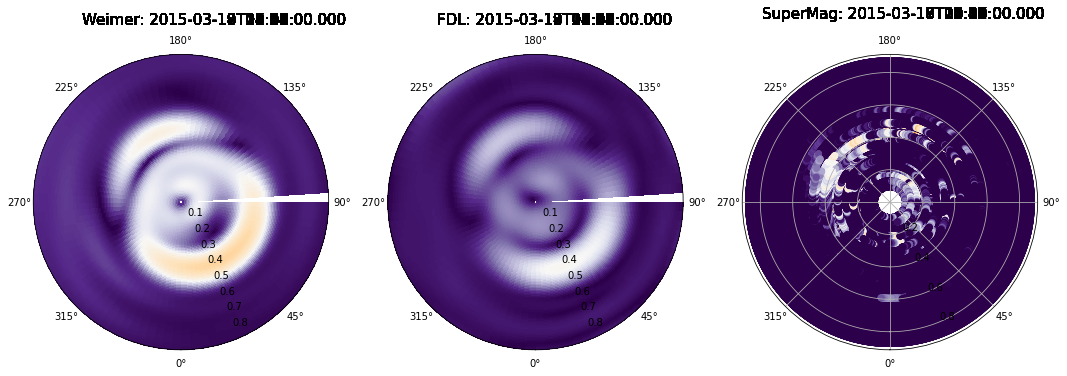

In [ ]:
 
k = 'dbn'
fig1 = plt.figure(figsize=(18,6))
camera = Camera(fig1)
theta = weimer_mlt 
phi = weimer_colat 
cmap='PuOr_r'
ax1 = fig1.add_subplot(131, projection='polar')
ax1.set_theta_offset(-np.pi/2)
ax2 = fig1.add_subplot(132, projection='polar')
ax2.set_theta_offset(-np.pi/2)
ax3 = fig1.add_subplot(133, projection='polar')
ax3.set_theta_offset(-np.pi/2)
for time_ind,d in enumerate(weimer['JDTIMES']):
  dt = Time(d,format='jd').to_value("fits")
  dbH = np.sqrt(np.square(Targets['dbn'][time_ind])+np.square(Targets['dbe'][time_ind]))
  maxval=np.nanmax(dbH)
  minval=np.nanmin(dbH)
  norm=SqueezedNorm(vmin=minval, vmax=maxval, mid=np.nanmean(dbH), s1=1, s2=1)

  dbH = np.sqrt(np.square(weimer_predictions_gif['dbe'][time_ind])+np.square(weimer_predictions_gif['dbn'][time_ind]))
  c1=ax1.pcolormesh(theta,phi,dbH ,cmap=cmap,norm=norm)
  ax1.text(3.65,1.2,f"Weimer: {dt}",fontsize=15)

  dbH = np.sqrt(np.square(fdl_on_weimergrid_gif['dbe'][...,time_ind])+np.square(fdl_on_weimergrid_gif['dbn'][...,time_ind]))
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)  
  ax2.text(3.65,1.2,f"FDL: {dt}",fontsize=15)

  dbH = np.sqrt(np.square(Mcolat_sup_all['dbe'][time_ind])+np.square(Mcolat_sup_all['dbn'][time_ind]))
  c3=ax3.scatter(MLT_sup_all[k][time_ind],Mcolat_sup_all[k][time_ind], c=Targets[k][time_ind],cmap=cmap,norm=norm)
  ax3.text(3.75,1.38,f"SuperMag: {dt}",fontsize=15)
  camera.snap()

In [ ]:
from IPython.display import HTML
animation = camera.animate()
HTML(animation.to_html5_video())

Animation movie is 34047933 bytes, exceeding the limit of 20971520.0. If you're sure you want a large animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB).


In [ ]:
animation.save('dbH.mp4')

In [ ]:
 
k = 'dbe'
fig1 = plt.figure(figsize=(18,6))
# camera = Camera(fig1)
theta = weimer_mlt 
phi = weimer_colat 
cmap='PuOr_r'
ax1 = fig1.add_subplot(131, projection='polar')
ax1.set_theta_offset(-np.pi/2)
ax2 = fig1.add_subplot(132, projection='polar')
ax2.set_theta_offset(-np.pi/2)
ax3 = fig1.add_subplot(133, projection='polar')
ax3.set_theta_offset(-np.pi/2)
for time_ind,d in enumerate(weimer['JDTIMES'][:2]):
  dt = Time(d,format='jd').to_value("fits")

  maxval=np.nanmax(Targets[k][time_ind])
  minval=np.nanmin(Targets[k][time_ind])
  norm=SqueezedNorm(vmin=minval, vmax=maxval, mid=0, s1=2, s2=2)

  c1=ax1.pcolormesh(theta,phi, weimer_predictions_gif[k][time_ind],cmap=cmap,norm=norm)
  ax1.text(3.65,1.2,f"Weimer: {dt}",fontsize=15)

  c2=ax2.pcolormesh(theta,phi, fdl_on_weimergrid_gif[k][...,time_ind],cmap=cmap,norm=norm)  
  ax2.text(3.65,1.2,f"FDL: {dt}",fontsize=15)

  c3=ax3.scatter(MLT_sup_all[k][time_ind],Mcolat_sup_all[k][time_ind], c=Targets[k][time_ind],cmap=cmap,norm=norm)
  ax3.text(3.75,1.38,f"SuperMag: {dt}",fontsize=15)
  # camera.snap()

In [ ]:
 
k = 'dbn'
fig1 = plt.figure(figsize=(18,6))
camera = Camera(fig1)
theta = weimer_mlt 
phi = weimer_colat 
cmap='PuOr_r'
ax1 = fig1.add_subplot(131, projection='polar')
ax1.set_theta_offset(-np.pi/2)
ax2 = fig1.add_subplot(132, projection='polar')
ax2.set_theta_offset(-np.pi/2)
ax3 = fig1.add_subplot(133, projection='polar')
ax3.set_theta_offset(-np.pi/2)
for time_ind,d in enumerate(weimer['JDTIMES'][::2]):
  dt = Time(d,format='jd').to_value("fits")

  maxval=np.nanmax(Targets[k][time_ind])
  minval=np.nanmin(Targets[k][time_ind])
  norm=SqueezedNorm(vmin=minval, vmax=maxval, mid=0, s1=2, s2=2)

  c1=ax1.pcolormesh(theta,phi, weimer_predictions_gif[k][time_ind],cmap=cmap,norm=norm)
  ax1.text(3.65,1.2,f"Weimer: {dt}",fontsize=15)

  c2=ax2.pcolormesh(theta,phi, fdl_on_weimergrid_gif[k][...,time_ind],cmap=cmap,norm=norm)  
  ax2.text(3.65,1.2,f"FDL: {dt}",fontsize=15)

  c3=ax3.scatter(MLT_sup_all[k][time_ind],Mcolat_sup_all[k][time_ind], c=Targets[k][time_ind],cmap=cmap,norm=norm)
  ax3.text(3.75,1.38,f"SuperMag: {dt}",fontsize=15)
  camera.snap()
  
# cb= fig1.colorbar(c1, shrink=0.5)
# cb.set_label(k,fontsize=15)
# cb= fig1.colorbar(c2, shrink=0.5)
# cb.set_label(k,fontsize=15)
# cb= fig1.colorbar(c3, shrink=0.5)
# cb.set_label(k,fontsize=15)